In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 12.8MB/s 
     |████████████████████████████████| 317kB 55.7MB/s 


In [5]:
#IMPORTS

import pandas as pd
data=pd.read_csv("properties - Sheet2.csv")
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *
import math
import random
import numpy as np

In [6]:
#Agent-based fungi model global variables and classes

global dailyTemperature, dailyMoisture, day, decomposed 
global longitude, latitude
global fungi  
global canSpore
canSpore = False


class fungus: 
  pass

In [7]:
global dailyTemperature, dailyMoisture

from netCDF4 import Dataset

surface_temp = Dataset("air.sig995.2020.nc", 'r', format='NETCDF4')
moist_data = Dataset("drive/MyDrive/fungi/moisture.nc", 'r', format='NETCDF4')

air_lats = surface_temp.variables['lat'][:]
air_lons = surface_temp.variables['lon'][:]
time = surface_temp.variables['time'][:]
air = surface_temp.variables['air'][:]
moistures=moist_data.variables['soilw'][:]
moist_lats = moist_data.variables['lat'][:]
moist_lons = moist_data.variables['lon'][:]


def get_air_lon_index(x):
  return np.abs(air_lons - x).argmin()
def get_air_lat_index(y):
  return np.abs(air_lats - y).argmin()
def get_moist_lon_index(x):
  return np.abs(moist_lons - x).argmin()
def get_moist_lat_index(y):
  return np.abs(moist_lats - y).argmin()
def get_tindex(t):
  return t%365
def get_temp(t,x,y):
  return air[get_tindex(t),get_air_lat_index(y),get_air_lon_index(x)]-273.15
def get_mpa(t, x, y):
  if np.ma.is_masked(moistures[t,get_moist_lat_index(y),get_moist_lon_index(x)]) :
    print("Error with the get_mpa function")
    sys.exit()
  volume=moistures[t,get_moist_lat_index(y),get_moist_lon_index(x)]
  return (((0.435-volume)*4)**4)

In [8]:
#functions related to competition between fungi

def area(fun):
  return math.pi * (fun.radius) ** 2


def intersection(fun1, fun2):

    d = math.sqrt( (fun1.x - fun2.x)**2 + (fun1.y - fun2.y)**2 )

    if d < fun1.radius + fun2.radius:

      a = (fun1.radius) ** 2
      b = (fun2.radius) ** 2

      if (d <= abs(fun1.radius - fun2.radius)):
        return math.pi * min(a, b)

      else:
        x = (a - b + d * d) / (2 * d)
        z = x * x
        y = math.sqrt(a - z)

        return a * math.asin(y / (fun1.radius)) + b * math.asin(y / (fun2.radius)) - y * (x + math.sqrt(z + b - a))
      
    else:
      return 0


def overlappingRadius(fun1, fun2):

  return fun1.radius + fun2.radius - math.sqrt( (fun1.x - fun2.x)**2 + (fun1.y - fun2.y)**2 )


def getIndividualCombatScenarios(fun):
  
  global fungi

  for badguy in fungi:
    if intersection(fun, badguy) > min(area(fun)/20, area(badguy)/20) and (not (fun == badguy)):
      fun.dailyCompetitors.append(badguy)



def getAllCombatScenarios():
  
  global fungi

  for fun in fungi:
    getIndividualCombatScenarios(fun)


def combat(funguy, competitor):
  
  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi  
  global canSpore
  global punishmentConstant
  global rLost
  global moistureDeviation
  global day

  if (competitor in funguy.alreadyCompeted) or (funguy.deleted) or (competitor.deleted):
    return

  commonArea = intersection(funguy, competitor)
  if commonArea > 0:
    R_a = 1000*(funguy.rank) * getDailyMoistureSuitability(funguy, moistureDeviation[day])
    R_b = 1000*(competitor.rank) * getDailyMoistureSuitability(competitor, moistureDeviation[day])

    funguyPunishment = 1 - 1 / (1 + 10 ** ( (R_b - R_a)/400) )
    competitorPunishment = 1 - funguyPunishment 

    overlap = overlappingRadius(funguy, competitor)

    funguy.radius = funguy.radius - funguyPunishment * punishmentConstant
    funguyLostR = funguyPunishment*punishmentConstant 
    competitor.radius = competitor.radius - competitorPunishment * punishmentConstant 
    competitorLostR = competitorPunishment * punishmentConstant 

    if funguy.radius <= 0:
      funguy.deleted = True

    else:
      funguy.alreadyCompeted.append(competitor)
      funguy.hasFought = True

    if competitor.radius <= 0:
      competitor.deleted = True

    else:
      competitor.alreadyCompeted.append(funguy)
      competitor.hasFought = True

    rLost = rLost +(funguyLostR + competitorLostR) 
    
    
    



    






In [ ]:
def getDailyBaseDecompositionRate(fun):

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 

  if dailyTemperature <= 16:
    d = fun.tenDecomp - (10 - dailyTemperature) * (((fun.sixteenDecomp)-(fun.tenDecomp))/6)
   # return 1 - (1 - (d / 100)) ** (1/122)

  else:
    d = fun.twentyTwoDecomp + (dailyTemperature - 22) * (((fun.twentyTwoDecomp)-(fun.sixteenDecomp))/6)
    #return 1 - (1 - (d / 100)) ** (1/122)

  if d > 50:
    d = 50

  if d < 0:
    d = 0

  return 1 - (1 - (d / 100)) ** (1/122)

  

def eat(fun):

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 
  
  dailyD_r = getDailyBaseDecompositionRate(fun)
  decomposed = decomposed + dailyD_r * area(fun)

In [ ]:
#Growth

def getDailyMoistureSuitability(fun, a):  #a represents moisture level deviation from normal on a given day; + is positive - is negative

  global dailyMoisture

  return 1 - (2 * (fun.OM - (dailyMoisture+a))**2)/(fun.MNW ** 2)

def grow(fun):
  global moistureDeviation
  #if fun.radius < 1 :  #why was this if statement there?
  if fun.hasFought == False:
    fun.radius = fun.radius + (fun.HER) * max( getDailyMoistureSuitability(fun, moistureDeviation[day]), 0 ) 

In [ ]:
def reproduce(fun):  

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 
  global canSpore

  if fun.age < 7:
    return

  temp = randint(7)
  if temp == 0:
    n = 1 # math.floor(random.gauss(100,20))   #represents the number of spores produced
    for i in range(n):
      distance = 1000*exponential(1)
      direction = randint(360)
      rads = math.pi*direction/180
                        
      initializeFungus(fun, fun.x+(math.cos(rads))*distance, fun.y+(math.sin(rads))*distance,.01)
      
      

In [ ]:
def eatAll():

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi  

  for fun in fungi:
    eat(fun)


def combatAll():

  global dailyTemperature, dailyMoisture, day, decomposed 
  global fungi  
  global punishmentConstant
  global rLost

  rLost = 0
  getAllCombatScenarios()
  for funguy in fungi:
    for badguy in funguy.dailyCompetitors:
      combat(funguy, badguy)
  dailyRLost.append(rLost)
  

def updateClimate():

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 

  dailyTemperature = get_temp(day, longitude, latitude)
  dailyMoisture = get_mpa(day, longitude, latitude)

def growAll():

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 

  for fun in fungi:
    grow(fun)

def reproduceAll():
  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 

  for fun in fungi:
    reproduce(fun)


In [ ]:
#This initialize function assumes an even distribution of all species
def initialize(ecoregion, spawnable, punishment, n, a):   #a represents daily deviation from normal moisture levels in the environment 

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 

  global canSpore 
  global punishmentConstant #For reference look at def combat
  global dailyDecomposed
  global dailyRLost
  global moistureDeviation

  dailyDecomposed = []
  dailyRLost = []
  moistureDeviation = a

  fungi = []
  decomposed = 0
  eco = ecoregion
  canSpore = spawnable
  punishmentConstant = punishment 
  day = 0

  if eco == "arid":
    longitude = 16.8
    latitude = 13.9 
  
  elif eco == "semi-arid":
    longitude = 112.07
    latitude = 42.39
  
  elif eco == "boreal":
    longitude = -97.26887 
    latitude = 52.977988

  elif eco == "temperate":
    longitude = 120.03
    latitude = 31.40

  elif eco == "rainforest":
    longitude = 115.20
    latitude = .806

  else:
    print("Error: no ecoregion specified")
    sys.exit()

  perSpecies = n/34 #The number of fungi per species that gets initially included


  for i in range(34):
    j = 0
    while (j<perSpecies):
      fun = fungus()
      fun.hasFought = False
      fun.deleted = False
      fun.species = data.iloc[i][0]  #I had to look up the pandas DataFrame API to figure out how this worked
      fun.id = j                     #Probably won't end up using this
      fun.rank = data.iloc[i][1]
      fun.MNW = data.iloc[i][2]      #Moisture Niche Width
      fun.OM = data.iloc[i][3]       #Optimal Moisture
      fun.tenDecomp = data.iloc[i][4]#10 Degree decomp rate
      fun.sixteenDecomp = data.iloc[i][5]
      fun.twentyTwoDecomp = data.iloc[i][6]
      fun.HER = data.iloc[i][7]      #Hyphae extension rate
      # fun.TNW = data.iloc[i][8]      #Moisture Niche Width
      # fun.OT = data.iloc[i][9]       #Optimal Moisture

      fun.radius = .01               #Remember units are milimeters; this is the initial radius of our fungLs 
      

      coordsWork = False 
      while(coordsWork==False):
        fun.x = uniform(0,1000)        
        fun.y = uniform(0,1000)
        coordsWork = True
        for other in fungi:
          if intersection(fun, other)>0 and not (fun==other):
            coordsWork = False         

      
      fun.dailyCompetitors = []

      fun.age = 0

      fungi.append(fun)

      j+=1 #iterate the while loop

  random.shuffle(fungi)



def getSpeciesGroup(fun):
  if fun.HER < 2.58 and fun.MNW < 1.58:
    #fun.speciesGroup = 0  #'lightblue'
    return 'lightblue'

  elif fun.HER < 2.58 and fun.MNW > 1.57:
   # fun.speciesGroup = 1   #'g'
    return 'g'

  elif fun.HER > 2.57 and fun.MNW < 1.58:
    #fun.speciesGroup = 2    #'b'
    return 'b'

  else:
    #fun.speciesGroup = 3   #'r'
    return 'r'



def initializeFungus(parent, x, y, r):
  global fungi
  fun = fungus()
  fun.hasFought = False
  fun.deleted = False
  fun.species = parent.species  #I had to look up the pandas DataFrame API to figure out how this worked
  fun.id = len(fungi)                     #Probably won't end up using this
  fun.rank = parent.rank
  fun.MNW = parent.MNW      #Moisture Niche Width
  fun.OM = parent.OM       #Optimal Moisture
  fun.tenDecomp = parent.tenDecomp #10 Degree decomp rate
  fun.sixteenDecomp = parent.sixteenDecomp
  fun.twentyTwoDecomp = parent.twentyTwoDecomp
  fun.HER = parent.HER      #Hyphae extension rate
      # fun.TNW = data.iloc[i][8]      #Moisture Niche Width
      # fun.OT = data.iloc[i][9]       #Optimal Moisture

  fun.x = x        #I'm thinking we have a coordinate system where each unit is a milimeter,
  fun.y = y        #but feel free to change this 

  fun.radius = r               #Remember units are milimeters; this is the initial radius of our fungLs 
  fun.dailyCompetitors = []

  fun.age = 0

  fungi.append(fun)







In [ ]:
def update():

  global dailyTemperature, dailyMoisture, day, decomposed 
  global longitude, latitude
  global fungi 
  global canSpore
  global dailyDecomposed
  for fun in fungi:
    fun.alreadyCompeted = []
    fun.dailyCompetitors = []
    fun.hasFought = False

  updateClimate()
  eatAll()
  combatAll()
  growAll()
  
  if canSpore == True:
    reproduceAll()
  
  day = day+1
  for fun in fungi:
    fun.age = fun.age + 1

  # for fun in fungi:
  #   if fun.age > 31:
  #     fungi.remove(fun)
  
  for fun in fungi:
    if fun.deleted == True:
      fungi.remove(fun)

  dailyDecomposed.append(decomposed)

  random.shuffle(fungi)


In [ ]:
def observe():
  
  import numpy as np
  import matplotlib 
  
  global fungi

  cla()
  
  figure(figsize=(10,10))
  
  sizes = []
  colormap = np.array(['lightblue', 'g', 'b', 'r' ])

  speciesGroups = np.array([])
  for fun in fungi:
    size = area(fun)*(.375)
    sizes.append(size)
    speciesNumber = getSpeciesGroup(fun)
    speciesGroups = np.append(speciesGroups, speciesNumber)
  print(speciesGroups)

  plt.scatter([fun.x for fun in fungi], [fun.y for fun in fungi], s=sizes, c=speciesGroups) #c=speciesGroups
  
  axis('image')
  axis([0,1000,0,1000])
  plt.show()
  #savefig('Dragon Distribution')

['r' 'b' 'r' 'r' 'b' 'r' 'b' 'r' 'r' 'b' 'r' 'b' 'r' 'g' 'r' 'r' 'r' 'r'
 'r' 'b' 'lightblue' 'r' 'r' 'b' 'r' 'b' 'r' 'b' 'r' 'r' 'r']


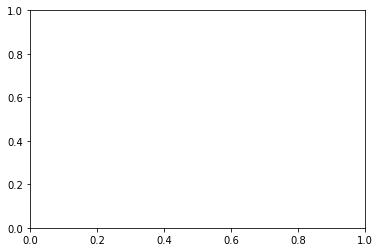

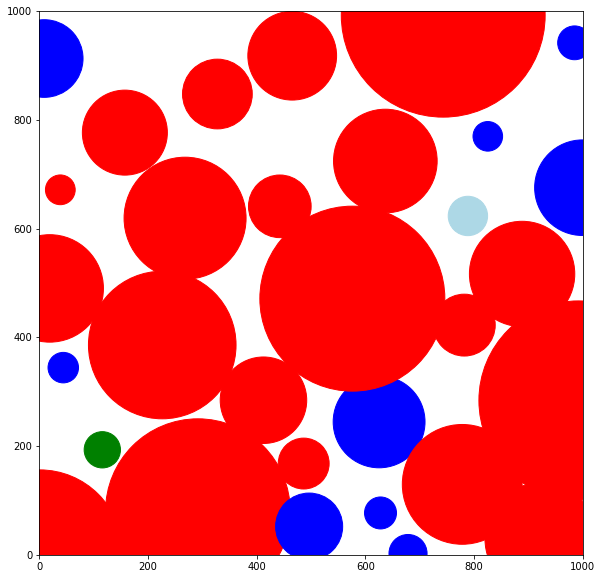

31
709708.5742474728
Total Area:
930570.9679114867


In [ ]:
#Just testing that initialization (which I'm not done with yet) is working so far

import numpy as np

global fungi
global dailyBiomasses

a=np.zeros(1000)
# np.ones(100)*2


initialize("arid", False, 50, 1000, a)
# print(len(fungi))
# observe()

# for i in range(1):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)


# for i in range(1):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)

# for i in range(10):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)

# for i in range(20):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)

# for i in range(50):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)


# for i in range(100):
#    update()
# observe()
# print(len(fungi)) 
# print(decomposed)




dailyBiomasses = []


for n in range(200):
  update()
  biomassesLightBlue = []
  biomassesGreen = []
  biomassesBlue = []
  biomassesRed = []

  biomasses = [biomassesLightBlue, biomassesGreen, biomassesBlue, biomassesRed]
  for fun in fungi:
    if getSpeciesGroup(fun)=='lightblue':
      biomassesLightBlue.append(fun)
    elif getSpeciesGroup(fun)=='g':
      biomassesGreen.append(fun)
    elif getSpeciesGroup(fun)=='b':
      biomassesBlue.append(fun)
    else:
      biomassesRed.append(fun)


  biomassSums = []
  i = 0
  for array in biomasses:
    biomass = 0
    for fun in array:
      biomass = biomass + area(fun)
    biomasses[i] = biomass 
    if(n==499):
      print(i)
      print(biomass)
    i = i+1

  dailyBiomasses.append(biomasses)

    

observe()
print(len(fungi)) 
print(decomposed)
print('Total Area:')
u = 0
for fun in fungi:
  u = u + area(fun)
print(u)
# print('Group areas:')
# print()
# print()
# print()
# print()

Text(0.5, 1.0, 'Daily Area Coverage per Isolate Group')

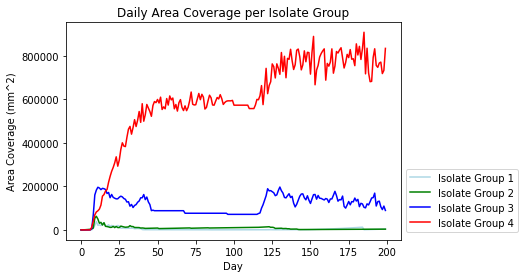

In [ ]:
#Biomass over time graph
global fungi
global dailyBiomasses

lightblue = []
green = []
blue = []
red = []
for array in dailyBiomasses:
  lightblue.append(array[0])
  green.append(array[1])
  blue.append(array[2])
  red.append(array[3])

lineLightblue = plt.plot(lightblue, color='lightblue', label='Isolate Group 1')
lineGreen = plt.plot(green, color='g', label = 'Isolate Group 2')
lineBlue = plt.plot(blue, color ='b', label = 'Isolate Group 3')
lineRed = plt.plot(red, color='r', label = 'Isolate Group 4')
xlabel('Day')
ylabel('Area Coverage (mm^2)')
#plt.legend((lineLightblue, lineGreen, lineBlue, lineRed),('Isolate Group 1', 'Isolate Group 2', 'Isolate Group 3', 'Isolate Group 4'))
bbox_to_anchor=(60,0)
plt.legend(bbox_to_anchor=(1,.35))
plt.title('Daily Area Coverage per Isolate Group')



#plt.plot(dailyBiomasses)


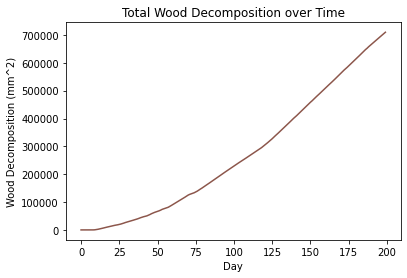

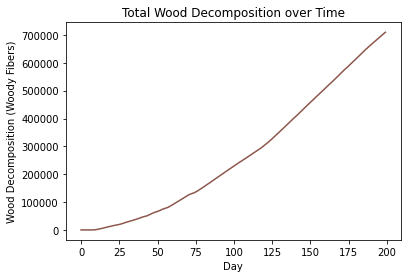

In [ ]:
#Decomposition over Time

global fungi
global decomposed
global dailyDecomposed

plt.plot(dailyDecomposed, color = "tab:brown")
xlabel("Day")
ylabel("Wood Decomposition (mm^2)")
title("Total Wood Decomposition over Time")

plt.show()

plt.plot(dailyDecomposed, color = "tab:brown")
xlabel("Day")
ylabel("Wood Decomposition (Woody Fibers)")
title("Total Wood Decomposition over Time")

plt.show()


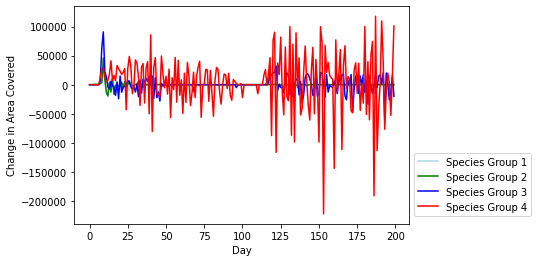

In [ ]:
#Change in area per day
global fungi
global dailyBiomasses

lightblue = []
green = []
blue = []
red = []

lightblueDerivs = []
greenDerivs = []
blueDerivs = []
redDerivs = []

for array in dailyBiomasses:
  lightblue.append(array[0])
  green.append(array[1])
  blue.append(array[2])
  red.append(array[3])

for i in range(len(dailyBiomasses)):
  if i == 0:
    lightblueDerivs.append(lightblue[0])
    greenDerivs.append(green[0])
    blueDerivs.append(blue[0])
    redDerivs.append(red[0])
  else:
    lightblueDerivs.append(lightblue[i]-lightblue[i-1])
    greenDerivs.append(green[i]-green[i-1])
    blueDerivs.append(blue[i]-blue[i-1])
    redDerivs.append(red[i]-red[i-1])
    

lineLightblue = plt.plot(lightblueDerivs, color='lightblue', label='Species Group 1')
lineGreen = plt.plot(greenDerivs, color='g', label = 'Species Group 2')
lineBlue = plt.plot(blueDerivs, color ='b', label = 'Species Group 3')
lineRed = plt.plot(redDerivs, color='r', label = 'Species Group 4')
xlabel('Day')
ylabel('Change in Area Covered')
#plt.legend((lineLightblue, lineGreen, lineBlue, lineRed),('Species Group 1', 'Species Group 2', 'Species Group 3', 'Species Group 4'))
bbox_to_anchor=(60,0)
plt.legend(bbox_to_anchor=(1,.35))


Text(0.5, 1.0, 'Daily Mutual Inhibition')

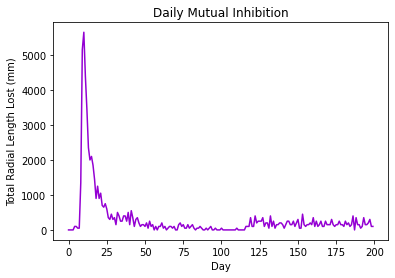

In [ ]:
#Daily net shrinkage due to combat
global dailyRLost

plt.plot(dailyRLost, color = "darkviolet")
xlabel('Day')
ylabel('Total Radial Length Lost (mm)')
title('Daily Mutual Inhibition')

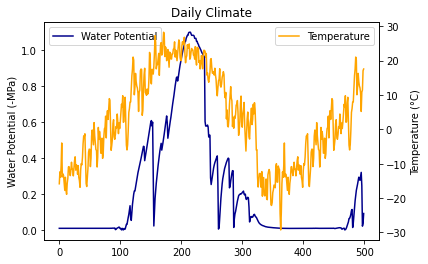

In [24]:
#Graphing MPA

fig, ax = plt.subplots()
ax2 = ax.twinx()

plotdata=[get_mpa(t,112.07,42.39) for t in range(500)]

weatherdata=[get_temp(t,112.07,42.39) for t in range(500)]

ax.plot(plotdata, color = "darkblue",label="Water Potential")
ax.set_ylabel('Water Potential (-MPa)')
ax.legend(loc="upper left")
ax2.plot(weatherdata, color = "orange",label="Temperature")
ax2.set_ylabel('Temperature (°C)')
title('Daily Climate')
xlabel('Day')

ax2.legend()

plt.savefig("weather.png",dpi=400,bbox_inches="tight")
  # if eco == "arid":
  #   longitude = 16.8
  #   latitude = 13.9 
  
  # elif eco == "semi-arid":
  #   longitude = 112.07
  #   latitude = 42.39
  
  # elif eco == "boreal":
  #   longitude = -97.26887 
  #   latitude = 52.977988

  # elif eco == "temperate":
  #   longitude = 120.03
  #   latitude = 31.40

  # elif eco == "rainforest":
  #   longitude = 115.20
  #   latitude = .806

  # else:
  #   print("Error: no ecoregion specified")
  #   sys.exit()


2
['b' 'r']


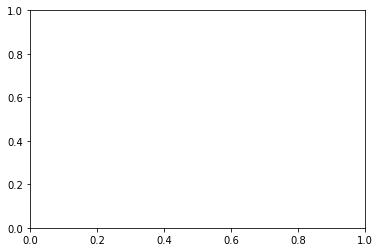

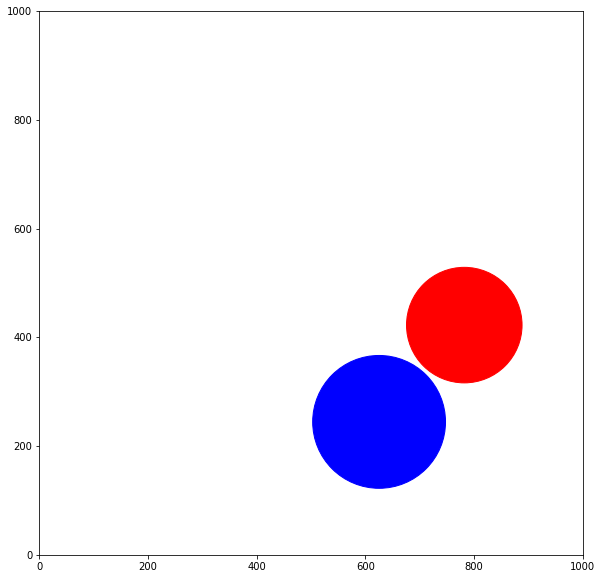

205


In [ ]:
#Showing how two fungi fight
global fungi
global day

while(len(fungi)>2):
  fungi.pop()

print(len(fungi))
for i in range(5):
  update()
observe()
print(day)

Text(0.5, 1.0, 'Daily Area Coverage per Isolate Group')

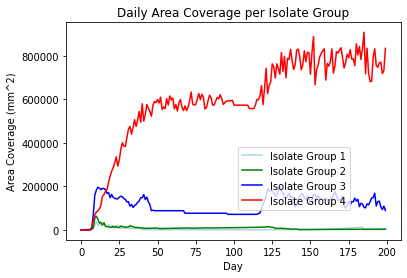

In [ ]:
global fungi
global dailyBiomasses

lightblue = []
green = []
blue = []
red = []
for array in dailyBiomasses:
  lightblue.append(array[0])
  green.append(array[1])
  blue.append(array[2])
  red.append(array[3])

lineLightblue = plt.plot(lightblue, color='lightblue', label='Isolate Group 1')
lineGreen = plt.plot(green, color='g', label = 'Isolate Group 2')
lineBlue = plt.plot(blue, color ='b', label = 'Isolate Group 3')
lineRed = plt.plot(red, color='r', label = 'Isolate Group 4')
xlabel('Day')
ylabel('Area Coverage (mm^2)')
#plt.legend((lineLightblue, lineGreen, lineBlue, lineRed),('Isolate Group 1', 'Isolate Group 2', 'Isolate Group 3', 'Isolate Group 4'))
bbox_to_anchor=(60,0)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0, 0.4, 0.45))
plt.title('Daily Area Coverage per Isolate Group')


In [ ]:
print("Decomposition: " + str(decomposed) )

Decomposition: 710927.0775703719
